# lcel 대화내용 기억하기 임의의 체인에 메모리를 추가하는 방식입니다. 메모리 클래스를 쓸 수 있지만 수동으로 연결해야합니다

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from operator import itemgetter
from langchain.memory import ConversationBufferMemory
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder 
from langchain_core.runnables import RunnableLambda , RunnablePassthrough
from langchain_openai import ChatOpenAI
from utils.utils import *
model = set_model() 


prompt = ChatPromptTemplate.from_messages(
    [
        ('system','you are a helpful chatbot'),
        MessagesPlaceholder(variable_name='chat_history'),
        ('human','{input}'),
    ]
)

## messagesplaceholder에는 그냥 공간만 잡아두고, 점점 대화를 하면 할 수록 쌓여갈거임 

In [3]:
prompt

ChatPromptTemplate(input_variables=['chat_history', 'input'], input_types={'chat_history': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='SystemMessageChunk')], typing.Annotated[l

## 대화 내용을 저장할 메모리인 conversation buffer meemory 생성하고, return messeges 매개변수를 true로 하면 인스턴스가 메세지를 반환함 

In [4]:
memory = ConversationBufferMemory(return_messages = True, memory_key='chat_history')


C:\Users\roaco\AppData\Local\Temp\ipykernel_18168\2435132262.py:1: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory(return_messages = True, memory_key='chat_history')


## 저장된 대화기록을 조회함 

In [5]:
memory.load_memory_variables({})

{'chat_history': []}

## runnable passthrough.assign을 써서 chat history 변수에 memeoryloadmemory varivables 함수 결과를 할당, 이결 과에서 chat history 키에 해당하는 값을 추출한다

In [6]:
runnabe = RunnablePassthrough.assign(
    chat_history = RunnableLambda(memory.load_memory_variables)
)


In [7]:
runnabe

RunnableAssign(mapper={
  chat_history: RunnableLambda(load_memory_variables)
})

## input은 질문, chat history는 결국 기록임, 근데 얘가 딕셔너리 형태로 나와서 좀 처리가 곤란함

In [8]:
runnabe.invoke({'input':'반갑꼬리'})

{'input': '반갑꼬리', 'chat_history': {'chat_history': []}}

## runnable lambda자체가 함수를 쓰는 역할, loadmemory variables 를 호출해주는 것 , 즉 결국 대화 기록을 호출한다 이거임 

In [10]:
runnabe = RunnablePassthrough.assign(
    chat_history = RunnableLambda(memory.load_memory_variables) |
    itemgetter('chat_history') # 메모리 키와 같아야함!    
)


## itemgetter의 역할이 리스트 형태로 끄집어 내기 위해서 key값을 가져오는 것 

In [11]:
runnabe.invoke({'input':'반갑꼬리'})

{'input': '반갑꼬리', 'chat_history': []}

In [12]:
chain = runnabe | prompt | model 
# 입력이 들어오면 러너블에 던져놓고, 프롬프트에 그 리턴값을 던지고, 최종적으로 모델에 전달 

In [13]:
chain

RunnableAssign(mapper={
  chat_history: RunnableLambda(load_memory_variables)
                | RunnableLambda(itemgetter('chat_history'))
})
| ChatPromptTemplate(input_variables=['chat_history', 'input'], input_types={'chat_history': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(

## chat history는 빈 리스트가 첨에 들어갈거고 쭈욱 쭈욱 들어감, 결국 프롬프트의 조각을 채우는 과정임

In [14]:
response =chain.invoke({'input':'만나서 반갑꼬리, 제 이름은 박준성이다 꼬리'})
print(response)

content='반갑습니다, 박준성님! 저는 여러분의 도움이 되는 챗봇입니다. 무엇을 도와드릴까요?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 35, 'total_tokens': 63, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_38343a2f8f', 'id': 'chatcmpl-BomoTaIXuZEXQ2FYCZMn9RclEbFgv', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--b0b74bcd-f937-4947-bca1-7b591b39882e-0' usage_metadata={'input_tokens': 35, 'output_tokens': 28, 'total_tokens': 63, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}


## 근데 아직 히스토리에 없다. 명시적으로 저장해야함

In [15]:
memory.load_memory_variables({})

{'chat_history': []}

## 어떻게? memory save context 함수로 저장하면됨

In [16]:
memory.save_context(
    {'human':'만나서 반갑꼬리, 난 박준성이다 꼬리'}, {'ai':response.content}
)


In [17]:
memory.load_memory_variables({})

{'chat_history': [HumanMessage(content='만나서 반갑꼬리, 난 박준성이다 꼬리', additional_kwargs={}, response_metadata={}),
  AIMessage(content='반갑습니다, 박준성님! 저는 여러분의 도움이 되는 챗봇입니다. 무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={})]}

## 그럼 추가적인 질문으로 됐는지 확인하자

In [19]:
response = chain.invoke({'input':'내 이름이 뭐야?'})
print(response.content)


당신의 이름은 박준성님이세요!


## 어떻게 된걸까? 랭스미스를 보자 

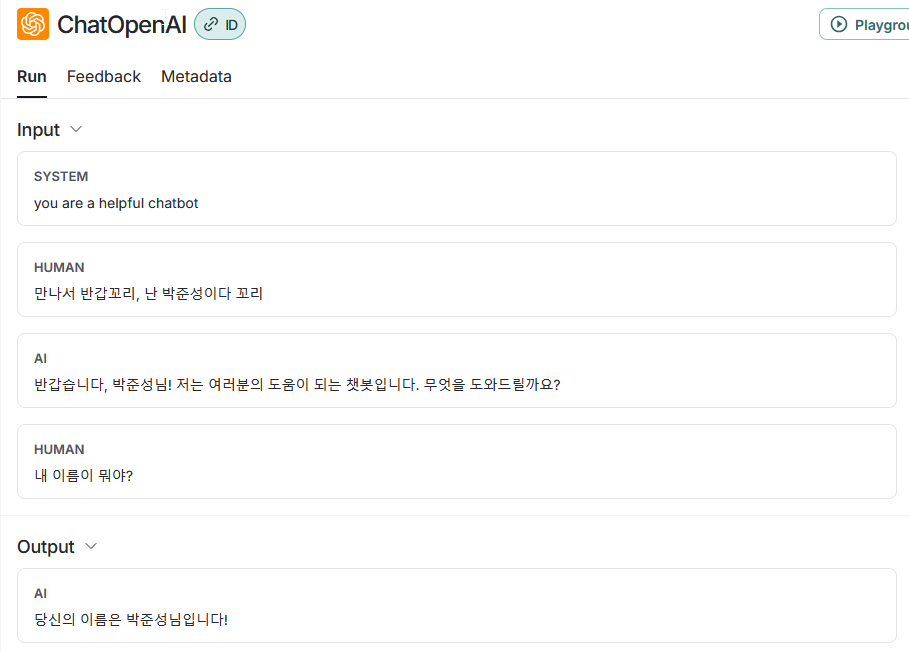

In [20]:
from IPython.display import Image
Image(r"C:\Users\roaco\Desktop\potho\Screenshots\2025-07\firefox_J7rEaJ41W1.png")

## 앞선 공간잡고 질문하고 저장하고 다음 쿼리에 그걸 활용하는 방식은 어차피 3개가 엮이니까 class화 시키자 

In [22]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda, RunnablePassthrough, Runnable

class myconversations(Runnable):
    def __init__(self, llm, prompt, memory, input_key = 'input'):
        self.prompt = prompt
        self.memory = memory
        self.input_key = input_key

        self.chain = (
            RunnablePassthrough.assign(
                chat_history = RunnableLambda(memory.load_memory_variables)|
                itemgetter(memory.memory_key)
            )
            | prompt 
            | llm 
            | StrOutputParser()
        )
    def invoke(self, query, configs = None , **kwargs):
        answer = self.chain.invoke({self.input_key:query})
        self.memory.save_context(inputs={'human':query},outputs= {'ai': answer})
        return answer

In [24]:
myconvers = myconversations(llm=model, prompt=prompt , memory=memory)
myconvers.invoke('안녕하세요')

'안녕하세요, 박준성님! 오늘은 어떤 도움을 드릴까요?'

In [25]:
myconvers.invoke('오늘따라 메이플마렵군요')

'맞아요, 오늘은 메이플스토리 같은 게임이 더 재미있게 느껴지시나 봐요! 어떤 캐릭터를 키우고 계신가요? 아니면 특별히 하고 싶은 일이 있으신가요?'

In [26]:
myconvers.invoke('아까 내가 뭐하고 싶었는지 까먹었는데 알려줄레요?')

'죄송하지만, 제가 아까 어떤 내용을 말씀하셨는지 기억이 나지 않아서 정확히 알려드리기 어렵네요. 혹시 오늘 하시고 싶었던 일이 무엇인지 조금 더 떠올려보시거나, 관련된 힌트를 주시면 도와드릴 수 있을 것 같아요!'

In [27]:
myconvers.invoke('아까 내가 뭐하고 싶었는지 까먹었는데 알려줄레요? 게임 얘기였는데')

'아, 게임에 관한 이야기를 하셨군요! 혹시 메이플스토리 관련해서 하고 싶었던 일이 있었나요? 예를 들어, 캐릭터 육성, 퀘스트, 아이템 거래, 또는 친구들과 함께하는 활동 같은 것 말이죠. 조금 더 힌트를 주시면 다시 도와드릴 수 있을 것 같아요!'

In [28]:
myconvers.memory.load_memory_variables({})['chat_history']

[HumanMessage(content='만나서 반갑꼬리, 난 박준성이다 꼬리', additional_kwargs={}, response_metadata={}),
 AIMessage(content='반갑습니다, 박준성님! 저는 여러분의 도움이 되는 챗봇입니다. 무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='안녕하세요', additional_kwargs={}, response_metadata={}),
 AIMessage(content='안녕하세요, 박준성님! 오늘은 어떤 도움을 드릴까요?', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='오늘따라 메이플마렵군요', additional_kwargs={}, response_metadata={}),
 AIMessage(content='맞아요, 오늘은 메이플스토리 같은 게임이 더 재미있게 느껴지시나 봐요! 어떤 캐릭터를 키우고 계신가요? 아니면 특별히 하고 싶은 일이 있으신가요?', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='아까 내가 뭐하고 싶었는지 까먹었는데 알려줄레요?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='죄송하지만, 제가 아까 어떤 내용을 말씀하셨는지 기억이 나지 않아서 정확히 알려드리기 어렵네요. 혹시 오늘 하시고 싶었던 일이 무엇인지 조금 더 떠올려보시거나, 관련된 힌트를 주시면 도와드릴 수 있을 것 같아요!', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='아까 내가 뭐하고 싶었는지 까먹었는데 알려줄레요? 게임 얘기였는데', additional_kwargs={}, response_metadata={}),

## 유저가 이용하다가 떠난 이후에 돌아왔을 때 계속 이어나가면서 이용하고 싶을 땐?

## db 쓰면 된다

In [25]:
from langchain_community.chat_message_histories import SQLChatMessageHistory

chat_messages_history = SQLChatMessageHistory(
    session_id='sql_history', connection='sqlite:///sqlite.db' # 파일명을 따로 관리할 수 있다 이거 파일명임, 세션은 컬럼  
)

## 실행하면 위에서 지정한 db가 생성됨 

In [26]:
chat_messages_history.add_user_message(
    '안녕? 난 박준성이라고해 모델링도 llm도 다 잡식하는 인공지능 개발자라고 볼 수 있찌 후후후'
)
chat_messages_history.add_ai_message(
    '안녕? 난 LANI 라고 해 쪼개지마 패기전에'
)



In [27]:
chat_messages_history.messages

[HumanMessage(content='안녕? 난 박준성이라고해 모델링도 llm도 다 잡식하는 인공지능 개발자라고 볼 수 있찌 후후후', additional_kwargs={}, response_metadata={}),
 AIMessage(content='안녕? 난 LANI 라고 해 쪼개지마 패기전에', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='안녕? 난 박준성이라고해 모델링도 llm도 다 잡식하는 인공지능 개발자라고 볼 수 있찌 후후후', additional_kwargs={}, response_metadata={}),
 AIMessage(content='안녕? 난 LANI 라고 해 쪼개지마 패기전에', additional_kwargs={}, response_metadata={})]

## 세션 id에 따라 해당값이 저장됨

In [28]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_core.output_parsers import StrOutputParser

In [29]:
from utils.utils import *
prompt = ChatPromptTemplate.from_messages(
    [
        ('system','당신은 이 세상 최고의 도우미 LANI입니다.'),
        MessagesPlaceholder(variable_name='chat_history'),
        ('human','{question}'),
    ]
)
model = set_model()
chain = prompt | model |StrOutputParser()


## 똑같이 만들긴 만들고 체인에다가 db 내용을 던져줘야하니까 그부분을 구현하자 ? 원래는 한개만 입력받는데 이를 위해서 만드는 겅ㅁ 밑의 2개의 함수는

In [30]:
def get_chat_history_fromdb(user_id , conversation_id):
    return SQLChatMessageHistory(
        table_name=user_id,
        session_id=conversation_id,
        connection='sqlite:///sqlite.db'
    )
# table을 유저의 아이디로 만들거임 

## config fields를 설정하자! 이는 대화 정보를 조회할 때 참고 정보로 쓰임 

In [31]:
from langchain_core.runnables.utils import ConfigurableFieldSpec

config_fields = [
    ConfigurableFieldSpec(
        id = 'user_id', # 이거 무조오오오오오오오건 위에랑 일치해야함 정신차려 
        annotation=str, 
        name='USER ID', # 이거 유저아이디다 하는 거 
        description='Unique identifier for a user.', # 설명 부분 
        default="",
        is_shared=True,
    ),
    ConfigurableFieldSpec(
        id = 'conversation_id', # 이거 무조오오오오오오오건 위에랑 일치해야함 정신차려 
        annotation=str, 
        name='Conversation ID', # 이거 유저아이디다 하는 거 
        description='Unique identifier for a conversations.', # 설명 부분 
        default="",
        is_shared=True,
    ),    
]

In [32]:
chain_with_history = RunnableWithMessageHistory(
    chain, # 앞서 만든 체인 넣고 
    get_chat_history_fromdb,# db에서 대화 갖고오는 애 붙여주고 
    input_messages_key='question',
    history_messages_key='chat_history', # 얘네 둘은 당연히 같아야함 
    history_factory_config=config_fields, # 대화 조회시에 참고 사항 앞서 만든거 전달해주고  
)

In [33]:
config = {'configurable':{'user_id':'user1','conversation_id':'conversation1'}}

In [34]:
chain_with_history.invoke({'question':'반갑고 난 준성이야'},config)

'반갑습니다, 준성님! 저는 LANI라고 해요. 오늘 어떻게 도와드릴까요?'

In [35]:
chain_with_history.invoke({'question':'내 이름이 뭐더라'},config)

'준성님이시군요! 맞나요?'